<h1>Accident Risk Predictions using Random Forests </h1>
<h3>Title:</h3> <em> Accidents prediction using extraTreesClassifier along with clustered view of training and testing data </em> 
<h3>Author:</h3> <em>Uttam Kumar</em>

<em> Note: The notebook only contains one sample of work from all different experiments that is being done, so that the code is clean and easily understandable </em>

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier as etf
from sklearn.model_selection import train_test_split
import warnings; warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
from feature_extraction import *
from sklearn.metrics import confusion_matrix
import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

<em> Define functions useful during predictions </em>

In [2]:
#function to plot feature importance of 15 features which are contributing most to the accidents
def plot_feature_imp(df,model,end_feat_num):
    #data" is the X dataframe and model is the SKlearn object
    #Mean Decrease in Impurity (MDI) calculates each feature importance as the sum over the number of splits 
    # (across all tress) that include the feature, proportionally to the number of samples it splits.
    feats = {} # a dict to hold feature_name: feature_importance
    for feature, importance in zip(df.columns, model.feature_importances_):
        feats[feature] = importance #add the name/value pair 
    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
    #to plot feature importance of 25 most contributing features
    importances.sort_values(by='Gini-importance').iloc[(end_feat_num-26):end_feat_num-1].plot(kind='bar', rot=90, figsize=(7, 4))

In [3]:
#evaluate result, using precision, recall and F1 score as metrics
def evaluate_result(actual,predicted):
    #create a df of actual and pred for ease of work
    pdf_data = {'actual':list(actual),'predicted':list(predicted)}
    actl_pred_df = pd.DataFrame(pdf_data,columns=['actual','predicted'])
    #actuals
    tot_act_acc = sum(actl_pred_df.actual)
    #print('Total no. of actual accidents for selected cities: ',tot_act_acc)
    tot_act_nonAcc = (len(actl_pred_df) - tot_act_acc)
    #print('Total no. of actual non-accidents for selected cities: ',tot_act_nonAcc)

    #predicted
    tot_recog_acc = sum(actl_pred_df['predicted'])
    #print('Total no. of predicted accidents for selected cities: ',tot_recog_acc)
    tot_recog_nonAcc = len(actl_pred_df) - tot_recog_acc
    #print('Total no. of predicted non-accidents for selected cities: ',tot_recog_nonAcc)

    #total no. of correctly predicted accidents and correctly predicted nonAccidents
    corr_acc = actl_pred_df.query('actual==1 & predicted==1')['predicted'].sum()
    corr_nonAcc = len(actl_pred_df.query('actual==0 & predicted==0')['predicted'])

    precision_acc = round((corr_acc/tot_recog_acc),2)
    precision_nonAcc = round((corr_nonAcc/tot_recog_nonAcc),2)
    recall_acc = round((corr_acc/tot_act_acc),2)
    recall_nonAcc = round((corr_nonAcc/tot_act_nonAcc),2)

    accF1 = round(((2*precision_acc*recall_acc)/(precision_acc+recall_acc)),2)
    nonAccF1 = round(((2*precision_nonAcc*recall_nonAcc)/(precision_nonAcc+recall_nonAcc)),2)

    return precision_acc,precision_nonAcc,recall_acc,recall_nonAcc,accF1,nonAccF1

In [4]:
#dummy function to get testing scores
def process_prediction(X,y,z,i_number_trees,max_features='auto'):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    #regr_1 = etf(n_estimators = i_number_trees, max_features= 'sqrt', n_jobs = 1)
    regr_1 = etf(n_estimators = i_number_trees, n_jobs = 1, max_features=max_features)
    regr_1.fit(X_train, np.ravel(y_train,order='C'))
    test_score = regr_1.score(X_test, y_test)
    y_pred = regr_1.predict(z)
    
    return test_score, y_pred

In [5]:
#function to get predictions
def process_pred(X,y,z,i_number_trees,max_features='auto'):
    regr_1 = etf(n_estimators = i_number_trees, n_jobs = 2, max_features=max_features, 
                 criterion='entropy')
    y=y.astype('int')
    #regr_1.fit(X, np.ravel(y,order='C'))  
    regr_1.fit(X, y)  
    y_pred = regr_1.predict(z)
    return regr_1, y_pred

In [6]:
#function to process predictions for a group of cities
def process_and_plot_cities(train_df,test_df,end_feat_num,no_of_trees,max_features='auto'):
    ##train file i.e. without benchmark dataset, #end_feat_num = 149
    X = train_df.values[:,0:end_feat_num-1]   #index 0 to 147 is passed , idx 148 is quarter41
    y = train_df.values[:,[end_feat_num-1]]   #indx 148 i.e quarter41 is passed
    z = test_df.values[:,0:end_feat_num-1]    #index 0 to 147 is passed for prediction

    #predicting
    #y_score, y_pred = process_prediction(X,y,z,no_of_trees,max_features)
    regr_1, y_pred = process_pred(X,y,z,no_of_trees,max_features)

    print('As per model predictions, the number of total accidents should be: ',int(sum(y_pred)))
    y_actual = test_df.values[:,[end_feat_num-1]].reshape([test_df.values[:,[end_feat_num-1]].shape[0],]).astype(int).tolist()
    print('In reality, total accidents that happened : ',sum(y_actual))

    print('\nFeature importance during prediction in benchmark period:')
    ##print(set(zip(test_df.columns, regr_1.feature_importances_)))
    plot_feature_imp(test_df.iloc[:,0:end_feat_num-1],regr_1,end_feat_num)
    return y_pred

In [7]:
#function to process prediction for a city
def process_and_plot_city(X_train,y_train,X_test,no_of_trees,max_features='auto'):
    #y_score_A1, y_pred_A1 = process_prediction(X,y,z,no_of_trees,max_features)
    regr_1, y_pred = process_pred(X_train,y_train,X_test,no_of_trees,max_features)
    return y_pred

In [8]:
#function to prepare a confusion matrix
def create_conf_matrix(expected, predicted, n_classes):
    m = [[0] * n_classes for i in range(n_classes)]
    for pred, exp in zip(predicted, expected):
        m[pred][exp] += 1
    return m

In [9]:
#function to calculate accuracy given the confusion matrix
def calc_accuracy(conf_matrix):
    t = sum(sum(l) for l in conf_matrix)
    return sum(conf_matrix[i][i] for i in range(len(conf_matrix))) / t

In [10]:
#function to plot a confusion matrix
def plot_confusion_matrix(df_confusion, title='Confusion matrix of accidents(1) and non-accidents(0) \n', cmap=plt.cm.Blues):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

In [11]:
def plot_figures(bx,by,mx,my,save_path,lbl1,lbl2):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.scatter(bx,by, s=10, c='b', marker="s", label=lbl1)
    ax1.scatter(mx,my, s=10, c='r', marker="o", label=lbl2)
    plt.title(save_path.replace('.png','').split('/')[-1])
    plt.legend(loc='upper right')
    plt.savefig(save_path, dpi=480)
    plt.show()

<h3> Using Accidents Dataset: Train & Test with only accidents records </h3>

<em> <b> Predicting for a slot of 15 minute interval for all geohashes(embeddings used) of the 6 cities 
    <br> All data being used for training and testing is prepared in arpDataProcessing.ipynb </b>  </em>

In [12]:
train_df = pd.read_csv('../data_files/train_etc_acc.csv')
test_df = pd.read_csv('../data_files/test_etc_acc.csv') 
print('train_df.shape: ',train_df.shape)
print('test_df.shape: ',test_df.shape)
actual = test_df['quarter41']
print('Actual number of accidents that happened in these cities: ',sum(actual))
print('Actual number of non-accidents in these cities: ',len(test_df)-sum(actual))

train_df.shape:  (12886, 216)
test_df.shape:  (2850, 216)
Actual number of accidents that happened in these cities:  229
Actual number of non-accidents in these cities:  2621


<em> First we try to see how the data points of two classes get clustered  </em>

<em>Running <b>t-SNE(t-distributed Stochastic Neighbor Embedding)</b> on time interval of 15 minutes (say 10:00 AM to 10:15 AM) on US Accidents dataset. We use different perplexities, i.e., 5, 45, 125 to see how the accidents cases differentiate from non-accidents. Visualizing the 2D data set in a scatter plot using different colors for cases from accidents and non-accidents classes. </em>

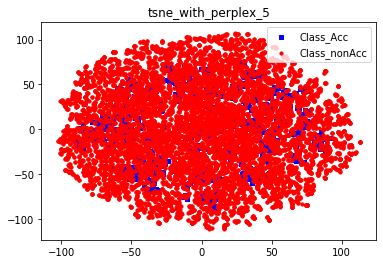

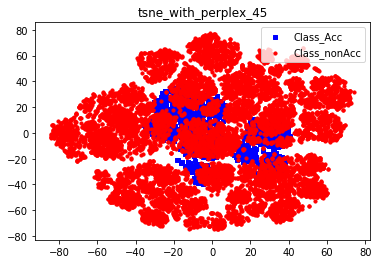

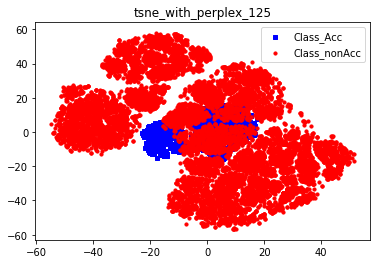

t-SNE completed for perplexity 5,45,125! for both classes on training data. Time elapsed: 392.17 seconds


In [13]:
st_tm = time.time()
for i in range(5):   
    if (i == 0 or i == 2 or i==4):
       p = (i+1)*(i+1)*5   #to plot images with different perplexity
       arp_acc_tsne = TSNE(perplexity=p,random_state=None).fit_transform(train_df[train_df['quarter41']==1])
       arp_non_acc_tsne = TSNE(perplexity=p,random_state=None).fit_transform(train_df[train_df['quarter41']==0])
       save_path = '../data_files/tsne_with_perplex_'+str(p)+'.png'
       plot_figures(arp_acc_tsne[:,0],arp_acc_tsne[:,1],arp_non_acc_tsne[:,0],arp_non_acc_tsne[:,1],save_path,'Class_Acc','Class_nonAcc')
print('t-SNE completed for perplexity 5,45,125! for both classes on training data. Time elapsed: {} seconds'.format(round((time.time()-st_tm),2)))

<em> With high perplexity we can see that more small clusters, probably being each of the geohash areas having non-accidents(red) are formed </em>

<em> Checking same on test data</em>

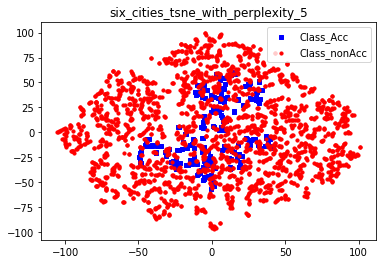

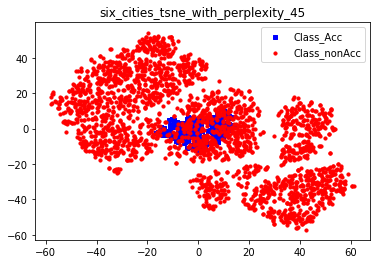

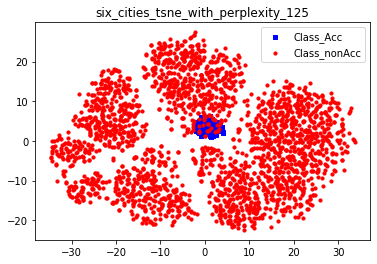

t-SNE completed for perplexity 5,45,125! for both classes on testing data. Time elapsed: 145.07 seconds


In [14]:
st_tm = time.time()
for i in range(5):
    if (i == 0 or i == 2 or i==4):
       p = (i+1)*(i+1)*5  #to plot images with different perplexity
       arp_acc_tsne = TSNE(perplexity=p,random_state=None).fit_transform(test_df[test_df['quarter41']==1])
       arp_non_acc_tsne = TSNE(perplexity=p,random_state=None).fit_transform(test_df[test_df['quarter41']==0])
       save_path = '../data_files/six_cities_tsne_with_perplexity_'+str(p)+'.png'
       plot_figures(arp_acc_tsne[:,0],arp_acc_tsne[:,1],arp_non_acc_tsne[:,0],arp_non_acc_tsne[:,1],save_path,'Class_Acc','Class_nonAcc')
print('t-SNE completed for perplexity 5,45,125! for both classes on testing data. Time elapsed: {} seconds'.format(round((time.time()-st_tm),2)))

<em> Since for t-SNE, the perplexity is related to the number of nearest neighbors and if we keep that low, the clusters are not cleary separable for our two classes. </em>

<em> Running <b>PCA(Principal Component Analysis)</b> on time interval of 15 minutes (say 10:00 AM to 10:15 AM) on US Accidents dataset. We use n_components as 2 to see how the accidents cases differentiate from non-accidents. Visualizing the 2D data set in a scatter plot using different colors for cases from accidents and non-accidents classes. <em>

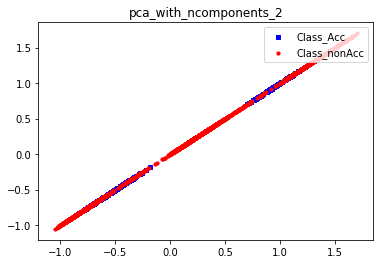

In [15]:
st_tm = time.time()
#with n_components = 2
arp_acc_pca = PCA(n_components=2,random_state=None).fit_transform(test_df[test_df['quarter41']==1])
arp_non_acc_pca = PCA(n_components=2,random_state=None).fit_transform(test_df[test_df['quarter41']==0])
save_path = '../data_files/pca_with_ncomponents_2.png'
plot_figures(arp_acc_pca[:,0],arp_acc_pca[:,0:1],arp_non_acc_pca[:,0],arp_non_acc_pca[:,0:1],save_path,'Class_Acc','Class_nonAcc')

<em> <b>Conclusion:</b></em> For PCA(concentrates on placing dissimilar data points far apart in a lower dimension representation), since it is a linear algorithm, we see that it is not be able to interpret the complex polynomial relationship between features(as is the case here with more number of features) while t-SNE is made to capture exactly that.

In [16]:
print(len(train_df.columns))
print(len(test_df.columns))
#dropping previous 8 time slots to avoid training on them
train_df = train_df.drop(['quarter33','quarter34','quarter35','quarter36','quarter37','quarter38','quarter39','quarter40'], axis=1)
test_df = test_df.drop(['quarter33','quarter34','quarter35','quarter36','quarter37','quarter38','quarter39','quarter40'], axis=1)
print('Number of columns in train dataset after removal of 2 hour slot columns',len(train_df.columns))
print('Number of columns in train dataset after removal of 2 hour slot columns',len(test_df.columns))

216
216
Number of columns in train dataset after removal of 2 hour slot columns 208
Number of columns in train dataset after removal of 2 hour slot columns 208


<em> <b> Predicting for a slot of 15 minute interval for all geohashes of the 6 cities </b>  </em>

As per model predictions, the number of total accidents should be:  60
In reality, total accidents that happened :  229

Feature importance during prediction in benchmark period:


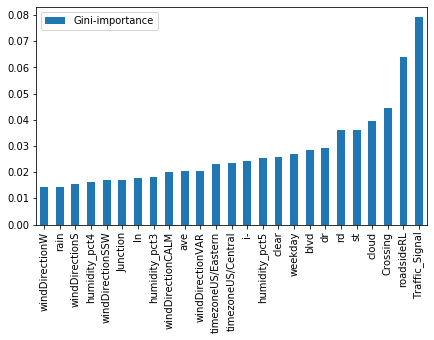

In [17]:
y_pred = process_and_plot_cities(train_df,test_df,test_df.shape[1],110) 

In [18]:
#calculating accuracy of total prediction of accidents and non-accidents for the 15 minute slot
cf = confusion_matrix(actual, y_pred)
acc = calc_accuracy(cf)
print(acc)

0.9049122807017543


<em> Since our dataset is very sparse with number of non-accidents very high in any single time slot, its better not to see ccuracy, but rather Precision, Recall and F1 scores of accidents predictions and non-accidents prediction, i.e. of both classes </em>

In [19]:
#metrics report of total prediction of accidents and non-accidents for the 15 minute slot
precision_acc, precision_nonAcc, recall_acc, recall_nonAcc, accF1, nonAccF1 = evaluate_result(actual,y_pred)
print('precisionAcc:{:.2f}, precisionNonAcc:{:.2f}, recallAcc:{:.2f}, recallNonAcc:{:.2f}, accF1:{:.2f}, nonAccF1:{:.2f}'.format(precision_acc,precision_nonAcc,recall_acc,recall_nonAcc,accF1,nonAccF1))

precisionAcc:0.15, precisionNonAcc:0.92, recallAcc:0.04, recallNonAcc:0.98, accF1:0.06, nonAccF1:0.95


<em> <b> CONCLUSION: F1 score on whole is very low for accidents, so we better provide more info like prior 2 hours accidents/non-accidents data while training. </b> </em>

<em> <b>Experimenting prediction for 6 cities with geohashes as one hot vector instead of geohash embedding, training with prev 8 time slots for 10 week/year and testing on next 2 week/year train test set </b> </em>

In [20]:
train_df = pd.read_csv('../data_files/train_set_6cities.csv')
test_df = pd.read_csv('../data_files/test_set_6cities.csv')
print('train_df.shape: ',train_df.shape)
print('test_df.shape: ',test_df.shape)
actual = test_df['quarter41']
print('Actual number of accidents that happened on the interstate highways in a time-slot for which we do the prediction: ',sum(actual))

train_df.shape:  (70094, 656)
test_df.shape:  (14440, 656)
Actual number of accidents that happened on the interstate highways in a time-slot for which we do the prediction:  229


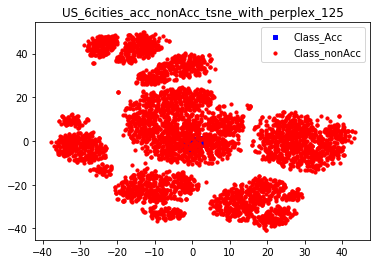

t-SNE completed for perplexity 125 for both classes on training data. Time elapsed: 63.97 seconds


In [44]:
st_tm = time.time()
for i in range(5):   
    if (i==4):   #(i == 0 or i == 2 or i==4):
       p = (i+1)*(i+1)*5   #to plot images with different perplexity
       arp_acc_tsne = TSNE(perplexity=p,random_state=None).fit_transform(test_df[test_df['quarter41']==1])
       arp_non_acc_tsne = TSNE(perplexity=p,random_state=None).fit_transform(test_df[test_df['quarter41']==0])
       save_path = '../data_files/US_6cities_acc_nonAcc_tsne_with_perplex_'+str(p)+'.png'
       plot_figures(arp_acc_tsne[:,0],arp_acc_tsne[:,1],arp_non_acc_tsne[:,0],arp_non_acc_tsne[:,1],save_path,'Class_Acc','Class_nonAcc')
print('t-SNE completed for perplexity 125 for both classes on training data. Time elapsed: {} seconds'.format(round((time.time()-st_tm),2)))

As per model predictions, the number of total accidents should be:  55
In reality, total accidents that happened :  229

Feature importance during prediction in benchmark period:


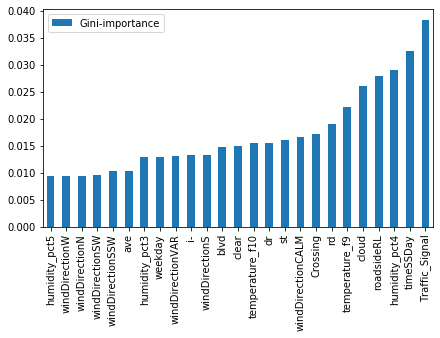

In [22]:
y_pred = process_and_plot_cities(train_df,test_df,test_df.shape[1],110) 

In [23]:
#metrics report of total prediction of accidents and non-accidents for the 15 minute slot
precision_acc, precision_nonAcc, recall_acc, recall_nonAcc, accF1, nonAccF1 = evaluate_result(actual,y_pred)
print('precisionAcc:{:.2f}, precisionNonAcc:{:.2f}, recallAcc:{:.2f}, recallNonAcc:{:.2f}, accF1:{:.2f}, nonAccF1:{:.2f}'.format(precision_acc,precision_nonAcc,recall_acc,recall_nonAcc,accF1,nonAccF1))

precisionAcc:0.11, precisionNonAcc:0.98, recallAcc:0.03, recallNonAcc:1.00, accF1:0.05, nonAccF1:0.99


<em> <b> Conclusion: F1 of accidents is 0.05, i.e. slight dip than before, still is very less </b>  </em>

<em> <b>Experimenting prediction for 6 cities with geohashes as one hot vector instead of geohash embedding, training without prev 8 time slots for 10 week/year and testing on next 2 week/year train test set </b> </em>

In [24]:
train_df = pd.read_csv('../data_files/train_set_6cities.csv')
test_df = pd.read_csv('../data_files/test_set_6cities.csv')
print('train_df.shape: ',train_df.shape)
print('test_df.shape: ',test_df.shape)
actual = test_df['quarter41']
print('Actual number of accidents that happened on the interstate highways in a time-slot for which we do the prediction: ',sum(actual))

train_df.shape:  (70094, 656)
test_df.shape:  (14440, 656)
Actual number of accidents that happened on the interstate highways in a time-slot for which we do the prediction:  229


In [25]:
print(len(train_df.columns))
print(len(test_df.columns))
#Dropping irrelevant attributes for the experiment
train_df = train_df.drop(['quarter33','quarter34','quarter35','quarter36','quarter37','quarter38','quarter39',
                          'quarter40'], axis=1)
test_df = test_df.drop(['quarter33','quarter34','quarter35','quarter36','quarter37','quarter38','quarter39',
                        'quarter40'], axis=1)
print('Columns in train dataset after removal other streets',len(train_df.columns))
print('Columns in test dataset after removal of other streets',len(test_df.columns))

656
656
Columns in train dataset after removal other streets 648
Columns in test dataset after removal of other streets 648


As per model predictions, the number of total accidents should be:  56
In reality, total accidents that happened :  229

Feature importance during prediction in benchmark period:


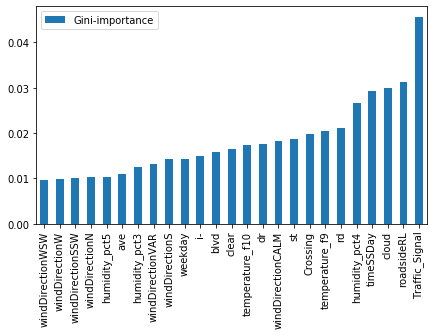

In [26]:
y_pred = process_and_plot_cities(train_df,test_df,test_df.shape[1],110) 

In [27]:
#metrics report of total prediction of accidents and non-accidents for the 15 minute slot
precision_acc, precision_nonAcc, recall_acc, recall_nonAcc, accF1, nonAccF1 = evaluate_result(actual,y_pred)
print('precisionAcc:{:.2f}, precisionNonAcc:{:.2f}, recallAcc:{:.2f}, recallNonAcc:{:.2f}, accF1:{:.2f}, nonAccF1:{:.2f}'.format(precision_acc,precision_nonAcc,recall_acc,recall_nonAcc,accF1,nonAccF1))

precisionAcc:0.07, precisionNonAcc:0.98, recallAcc:0.02, recallNonAcc:1.00, accF1:0.03, nonAccF1:0.99


<em> <b> CONCLUSION: We see that when we do not provide last 8 timesteps accidents data, then the accuracy of accidents prediction further decrease. So, better we provide this information during training. </b> </em>

<em> <b>Experimenting prediction street wise, trying with interstate highways over entire USA </b> </em>

In [28]:
train_df = pd.read_csv('../data_files/train_etc_str_acc.csv')
test_df = pd.read_csv('../data_files/test_etc_str_acc.csv') 
print('train_df.shape: ',train_df.shape)
print('test_df.shape: ',test_df.shape)
actual = test_df['quarter41']
print('Actual number of accidents that happened on the interstate highways in a time-slot for which we do the prediction: ',sum(actual))

train_df.shape:  (2890, 216)
test_df.shape:  (556, 216)
Actual number of accidents that happened on the interstate highways in a time-slot for which we do the prediction:  40


<em> <b> Visualizing how the accidents and non-accidents classes differentiate for the interstate highways data</b> </em>

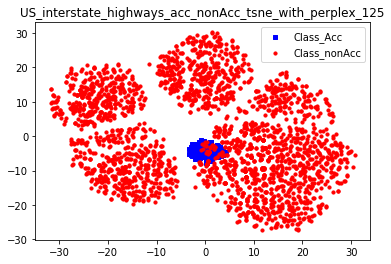

t-SNE completed for perplexity 125 for both classes on training data. Time elapsed: 50.58 seconds


In [29]:
st_tm = time.time()
for i in range(5):   
    if (i==4):   #(i == 0 or i == 2 or i==4):
       p = (i+1)*(i+1)*5   #to plot images with different perplexity
       arp_acc_tsne = TSNE(perplexity=p,random_state=None).fit_transform(train_df[train_df['quarter41']==1])
       arp_non_acc_tsne = TSNE(perplexity=p,random_state=None).fit_transform(train_df[train_df['quarter41']==0])
       save_path = '../data_files/US_interstate_highways_acc_nonAcc_tsne_with_perplex_'+str(p)+'.png'
       plot_figures(arp_acc_tsne[:,0],arp_acc_tsne[:,1],arp_non_acc_tsne[:,0],arp_non_acc_tsne[:,1],save_path,'Class_Acc','Class_nonAcc')
print('t-SNE completed for perplexity 125 for both classes on training data. Time elapsed: {} seconds'.format(round((time.time()-st_tm),2)))

In [30]:
print(len(train_df.columns))
print(len(test_df.columns))
#Dropping irrelevant attributes for the experiment
train_df = train_df.drop(['quarter33','quarter34','quarter35','quarter36','quarter37','quarter38','quarter39',
                          'quarter40','quarter41','rd','st','dr','ave','blvd','ln','highway','pkwy','hwy','way','pl',
                          'road','us-','creek','cir','hill', 'route','trl','valley','ridge','pike','fwy',
                          'river'], axis=1)
test_df = test_df.drop(['quarter33','quarter34','quarter35','quarter36','quarter37','quarter38','quarter39',
                        'quarter40','quarter41', 'rd','st','dr','ave','blvd','ln','highway','pkwy','hwy','way','pl',
                        'road','us-','creek','cir','hill','route','trl','valley','ridge','pike','fwy',
                        'river'], axis=1)
print('Columns in train dataset after removal other streets',len(train_df.columns))
print('Columns in test dataset after removal of other streets',len(test_df.columns))

216
216
Columns in train dataset after removal other streets 184
Columns in test dataset after removal of other streets 184


<em> <b> Predicting... </b> </b>

As per model predictions, the number of total accidents should be:  299
In reality, total accidents that happened :  278

Feature importance during prediction in benchmark period:


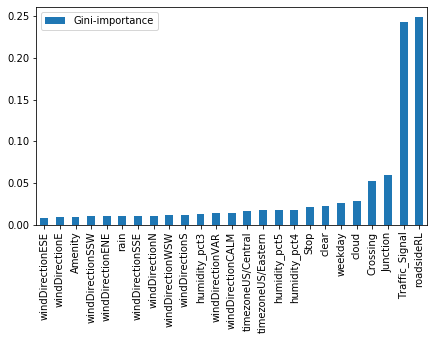

In [31]:
y_pred = process_and_plot_cities(train_df,test_df,test_df.shape[1],110) 

In [32]:
#metrics report of total prediction of accidents and non-accidents for the 15 minute slot
precision_acc, precision_nonAcc, recall_acc, recall_nonAcc, accF1, nonAccF1 = evaluate_result(actual,y_pred)
print('precisionAcc:{:.2f}, precisionNonAcc:{:.2f}, recallAcc:{:.2f}, recallNonAcc:{:.2f}, accF1:{:.2f}, nonAccF1:{:.2f}'.format(precision_acc,precision_nonAcc,recall_acc,recall_nonAcc,accF1,nonAccF1))

precisionAcc:0.07, precisionNonAcc:0.93, recallAcc:0.52, recallNonAcc:0.46, accF1:0.12, nonAccF1:0.62


<em> <b>Conclusion:</b> Accidents prediction on interstate highways has a lower precision than predicting geohash wise, however, F1 score is better due to high recall. </em>

<em> <b> Predicting for a slot of 15 minute, with training data that includes accidents/non-accidents within 2 hours before from this 15 minute slot, using geohash embeddings </b> </em>

In [33]:
train_df = pd.read_csv('../data_files/train_etc_acc.csv')
test_df = pd.read_csv('../data_files/test_etc_acc.csv') 
print('train_df.shape: ',train_df.shape)
print('test_df.shape: ',test_df.shape)
actual = test_df['quarter41']
print('Actual number of accidents that happened in these cities: ',sum(actual))
print('Actual number of non-accidents in these cities: ',len(test_df)-sum(actual))

train_df.shape:  (12886, 216)
test_df.shape:  (2850, 216)
Actual number of accidents that happened in these cities:  229
Actual number of non-accidents in these cities:  2621


As per model predictions, the number of total accidents should be:  170
In reality, total accidents that happened :  229

Feature importance during prediction in benchmark period:


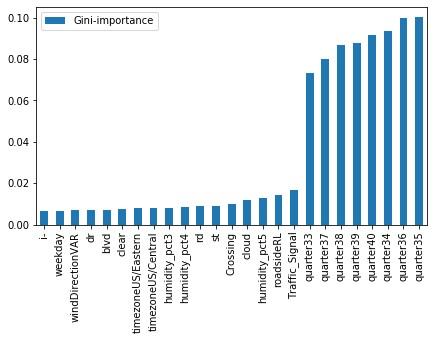

In [34]:
y_pred = process_and_plot_cities(train_df,test_df,test_df.shape[1],110)

In [35]:
#calculating accuracy of total prediction of accidents and non-accidents for the 15 minute slot
cf = confusion_matrix(actual, y_pred)
acc = calc_accuracy(cf)
print(acc)

0.9792982456140351


In [36]:
#metrics report of total prediction of accidents and non-accidents for the 15 minute slot
precision_acc, precision_nonAcc, recall_acc, recall_nonAcc, accF1, nonAccF1 = evaluate_result(actual,y_pred)
print('precisionAcc:{:.2f}, precisionNonAcc:{:.2f}, recallAcc:{:.2f}, recallNonAcc:{:.2f}, accF1:{:.2f}, nonAccF1:{:.2f}'.format(precision_acc,precision_nonAcc,recall_acc,recall_nonAcc,accF1,nonAccF1))

precisionAcc:1.00, precisionNonAcc:0.98, recallAcc:0.74, recallNonAcc:1.00, accF1:0.85, nonAccF1:0.99


<em> <b>CONCLUSION: This seems to be too high precision for accidents, and is obvious as we were training with only accidents data. So next we mix the non-accidents data in these 2 hours i.e. we add up records where no accidents have happened in those 2 hours. </b> </em>

<h3> Using Accidents Dataset: Train & Test with accidents & non-accidents records in 2 hours training slots(8)</h3>

<em> Predicting for a slot of 15 minute, with training and testing data being within 2 hours before this 15 minute slot. </em>

In [37]:
train_df = pd.read_csv('../data_files/train_etc_accNonacc.csv')
test_df = pd.read_csv('../data_files/test_etc_accNonacc.csv') 
print('train_df.shape: ',train_df.shape)
print('test_df.shape: ',test_df.shape)
actual = test_df['quarter41']
print('Actual number of accidents that happened in these cities: ',sum(actual))
print('Actual number of non-accidents in these cities: ',len(test_df)-sum(actual))

train_df.shape:  (26044, 216)
test_df.shape:  (5516, 216)
Actual number of accidents that happened in these cities:  229
Actual number of non-accidents in these cities:  5287


As per model predictions, the number of total accidents should be:  84
In reality, total accidents that happened :  229

Feature importance during prediction in benchmark period:


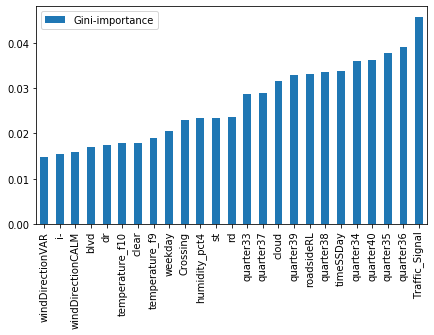

In [38]:
y_pred = process_and_plot_cities(train_df,test_df,test_df.shape[1],110)

In [39]:
#calculating accuracy of total prediction of accidents and non-accidents for the 15 minute slot
cf = confusion_matrix(actual, y_pred)
acc = calc_accuracy(cf)
print(acc)

0.9501450326323423


In [40]:
#metrics report of total prediction of accidents and non-accidents for the 15 minute slot
precision_acc, precision_nonAcc, recall_acc, recall_nonAcc, accF1, nonAccF1 = evaluate_result(actual,y_pred)
print('precisionAcc:{:.2f}, precisionNonAcc:{:.2f}, recallAcc:{:.2f}, recallNonAcc:{:.2f}, accF1:{:.2f}, nonAccF1:{:.2f}'.format(precision_acc,precision_nonAcc,recall_acc,recall_nonAcc,accF1,nonAccF1))

precisionAcc:0.23, precisionNonAcc:0.96, recallAcc:0.08, recallNonAcc:0.99, accF1:0.12, nonAccF1:0.97


<em> <b> CONCLUSION: Precision, Recall and F1 of Accidents prediction is still very low. </b> </em>

<em> To further improve, we better use the description of all the traffic events in vector form which until now was not used because the Accidents dataset we were currently working, had only accidents records and thus for all descriptions it has 'accidents' mentioned instead of it in reality being many other traffic events like 
congestion, construction, flow-incident i.e. animal on road etc. Thus, to further improve accuracy of accidents prediction and bring in more quality in our prediction, we now work upon the Traffic events dataset annotated with the weather factors from Weather dataset and the Points of Interests from Open Street Map. For this we created the train and test sets using Traffic and Weather dataset as per notebook arpDataProcessingForModels.ipynb  </em>

<h3> Using Traffic Events + Weather Events Dataset i.e. accidents and non-accidents all records </h3>

<em> Predicting for a slot of 15 minute, with training and testing data being within 2 hours before this 15 minute slot. </em> <br>
<em> This data is also having also the description of traffic events encoded into vectors, as prepared in arpDataProcessingForModels.ipynb </em>

In [41]:
#loading processed dataset of a city at a time and then getting metrics report
X_train,y_train,X_test,y_test = load_city_data('Atlanta')
y_pred = process_and_plot_city(X_train,y_train,X_test,110)
precision_acc, precision_nonAcc, recall_acc, recall_nonAcc, accF1, nonAccF1 = evaluate_result(y_test,y_pred)
print('accPrecision:{:.2f}, nonAccPrecision:{:.2f}, accRecall:{:.2f}, nonAccRecall:{:.2f}, accF1:{:.2f}, nonAccF1:{:.2f}'.format(precision_acc,precision_nonAcc,recall_acc,recall_nonAcc,accF1,nonAccF1))

accPrecision:0.68, nonAccPrecision:0.87, accRecall:0.47, nonAccRecall:0.94, accF1:0.56, nonAccF1:0.90


0.8425447316103379


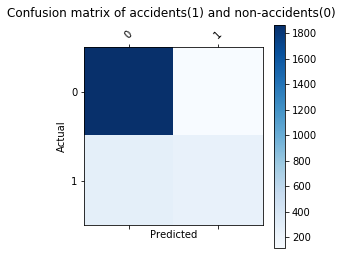

In [42]:
#cf = create_conf_matrix(y_test,y_pred,2)
cf = confusion_matrix(y_test, y_pred)   #directly using the function from sklearn package
acc = calc_accuracy(cf)
print(acc)
df_confusion = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
plot_confusion_matrix(df_confusion)

In [43]:
#looping over all the cities to get avg scores
cities = ['Houston', 'Atlanta', 'LosAngeles', 'Charlotte', 'Dallas', 'Austin']
sm_accPrecision, sm_accRecall, sm_accF1 = 0, 0, 0
for city in cities:
    #loading processed dataset of a city at a time
    X_train,y_train,X_test,y_test = load_city_data(city)
    y_pred = process_and_plot_city(X_train,y_train,X_test,300)
    precision_acc, precision_nonAcc, recall_acc, recall_nonAcc, accF1, nonAccF1 = evaluate_result(y_test,y_pred)
    sm_accPrecision += precision_acc
    sm_accRecall += recall_acc
    sm_accF1 += accF1
    print('Metrics for: ',city)
    print('accPrecision:{:.2f}, nonAccPrecision:{:.2f}, accRecall:{:.2f}, nonAccRecall:{:.2f}, accF1:{:.2f}, nonAccF1:{:.2f}'.format(precision_acc,precision_nonAcc,recall_acc,recall_nonAcc,accF1,nonAccF1))
    print('\n')
print('Average accPrecision:{:.2f}'.format(round((sm_accPrecision/len(cities)),2)))
print('Average accRecall:{:.2f}'.format(round((sm_accRecall/len(cities)),2)))
print('Average accF1:{:.2f}'.format(round((sm_accF1/len(cities)),2)))

Metrics for:  Houston
accPrecision:0.62, nonAccPrecision:0.92, accRecall:0.43, nonAccRecall:0.96, accF1:0.51, nonAccF1:0.94


Metrics for:  Atlanta
accPrecision:0.68, nonAccPrecision:0.87, accRecall:0.48, nonAccRecall:0.94, accF1:0.56, nonAccF1:0.90


Metrics for:  LosAngeles
accPrecision:0.52, nonAccPrecision:0.85, accRecall:0.42, nonAccRecall:0.89, accF1:0.46, nonAccF1:0.87


Metrics for:  Charlotte
accPrecision:0.65, nonAccPrecision:0.87, accRecall:0.51, nonAccRecall:0.92, accF1:0.57, nonAccF1:0.89


Metrics for:  Dallas
accPrecision:0.49, nonAccPrecision:0.91, accRecall:0.24, nonAccRecall:0.97, accF1:0.32, nonAccF1:0.94


Metrics for:  Austin
accPrecision:0.62, nonAccPrecision:0.91, accRecall:0.53, nonAccRecall:0.93, accF1:0.57, nonAccF1:0.92


Average accPrecision:0.60
Average accRecall:0.44
Average accF1:0.50
